In [1]:
import pandas as pd
import numpy as np
import logging
import pyabf
from ipfx.sweep import Sweep,SweepSet
import ipfx.chirp as chirp
import ipfx.abf_dataset
import ipfx.feature_vectors as fv
import ipfx.time_series_utils as tsu
import matplotlib.pyplot as plt
import scipy.fftpack as fftpack
import scipy.signal as signal
import tkinter as tk
from tkinter import filedialog
import os
abf = pyabf.ABF('C:\\Users\\SMest\\Downloads\\cell_9_20709114.abf')
abf_chrip = pyabf.ATF('.\\0_20hz_in50s_vs.atf')
t = abf.sweepX
v = t
i = abf_chrip.sweepY[:]
for x in range(0,abf.sweepCount):
        abf.setSweep(x)
        v = np.vstack((v,abf.sweepY))
        i = np.vstack((i,abf_chrip.sweepY[:]))
v = v[1:]
i = i[1:]
t = abf.sweepX
v_list = v
i_list = i
down_rate = 20000

The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


In [2]:
def analyze_abf_chirp(abf, stimuli_abf, average='input'):
    t = abf.sweepX
    v = t
    i = stimuli_abf.sweepY[:]
    if average=='input':
        for x in range(0,abf.sweepCount):
            abf.setSweep(x)
            v = np.vstack((v,abf.sweepY))
            i = np.vstack((i,stimuli_abf.sweepY[:]))
        v = v[1:]
        i = i[1:]
        t = abf.sweepX
        v, i, t = preprocess_data(v, i, t)
        resist, react, z = chirp_amp_phase(v,i,t)
    elif average=='output':
        resistance = []
        reactance = []
        for x in range(0,abf.sweepCount):
            abf.setSweep(x)
            v = abf.sweepY
            i = stimuli_abf.sweepY[:]
            v, i, t = preprocess_data(v, i, t, average=False)
            temp_resist, temp_react, temp_z = chirp_amp_phase(v,i,t)
            resistance.append(temp_resist)
            reactance.append(temp_react)
        resist = np.nanmean(np.vstack(resistance), axis=0)
        react = np.nanmean(np.vstack(reactance), axis=0)
        z = temp_z
    return resist, react, z
def preprocess_data(v_list, i_list, t, average=True):
    if average:
        avg_v = np.vstack(v_list).mean(axis=0)
        avg_i = np.vstack(i_list).mean(axis=0)
    else:
        avg_v = np.array(v_list)
        avg_i = np.array(i_list)
    current_rate = np.rint(1 / (t[1] - t[0]))
    if current_rate > down_rate:
        width = int(current_rate / down_rate)
        ds_v = ds_v = fv._subsample_average(avg_v, width)
        ds_i = fv._subsample_average(avg_i, width)
        ds_t = t[::width]
    else:
        ds_v = avg_v
        ds_i = avg_i
        ds_t = t
    return ds_v, ds_i, ds_t

def chirp_amp_phase(v,i, t, start=0.78089, end=49.21, down_rate=20000.0,
            min_freq=1, max_freq=19.5):
        """ Calculate amplitude and phase of chirp responses

        Parameters
        ----------
        sweep_set: SweepSet
            Set of chirp sweeps
        start: float (optional, default 0.6)
            Start of chirp stimulus in seconds
        end: float (optional, default 20.6)
            End of chirp stimulus in seconds
        down_rate: int (optional, default 2000)
            Sampling rate for downsampling before FFT
        min_freq: float (optional, default 0.2)
            Minimum frequency for output to contain
        max_freq: float (optional, default 40)
            Maximum frequency for output to contain

        Returns
        -------
        amplitude: array
            Aka resistance
        phase: array
            Aka reactance
        freq: array
            Frequencies for amplitude and phase results
        """
        ds_v, ds_i, ds_t = v, i, t
        start_index = tsu.find_time_index(ds_t, start)
        end_index = tsu.find_time_index(ds_t, end)

        N = len(ds_v[start_index:end_index])
        T = ds_t[1] - ds_t[0]
        xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

        v_fft = fftpack.fft(ds_v[start_index:end_index])
        i_fft = fftpack.fft(ds_i[start_index:end_index])
        Z = v_fft / i_fft
        R = np.real(Z)
        X = np.imag(Z)
        resistance = np.abs(Z)[0:N//2]
        reactance = np.arctan(X / R)[0:N//2]

        low_ind = tsu.find_time_index(xf, min_freq)
        high_ind = tsu.find_time_index(xf, max_freq)
        return resistance[low_ind:high_ind], reactance[low_ind:high_ind], xf[low_ind:high_ind]

# Using run_ABF_chirp.exe
This script works similar to the previous scripts. However it can be kinda finicky to get running.
Like previously it will prompt the user to select the directory where the chirp ABF's are stored. Its crucial that this folder only contains chirps of the same protocol.

![screen1](dist/screen1.png)

Next the script will prompt the use to select the stimulus used. Since the chirp files used a specialized custom waveform, trying to read the stimulus from the output ABF causes the program to crash. The program has to read the chirp stimulus protocol on its own as an independent file.

In most cases 0_20hz_in50s_vs should work:

![screen1](dist/screen2.png)

Similar to previous scripts you can also apply a "tag" to the output file:

![screen1](dist/screen3.png)

Next, indicate whether to average the sweeps before computing the freq - power relationships (Y). Or, compute the freq - power relationship for each sweep and then compute the average of the freq - power curves (N).
In most cases these produce the same result, so selecting (Y) or nothing should be okay:

![screen1](dist/screen4.png)


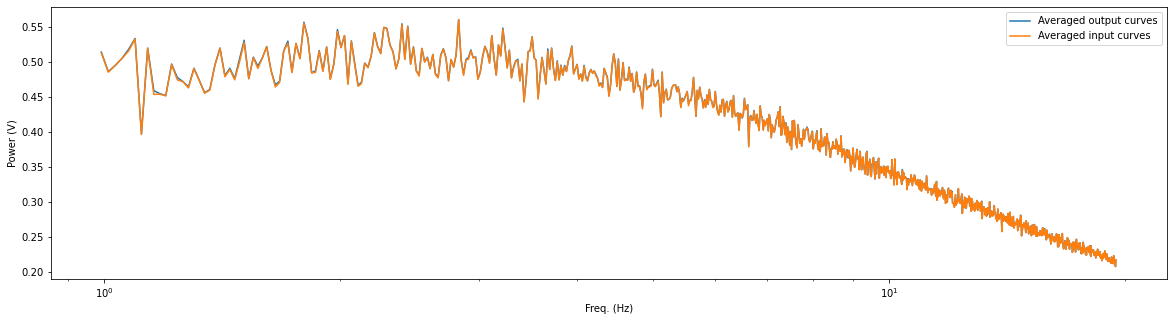

In [3]:
result_out = analyze_abf_chirp(abf, abf_chrip, average="output")
result_in = analyze_abf_chirp(abf, abf_chrip, average="input")
plt.figure(figsize=(20,5))
plt.plot(result_out[2], result_out[0], label="Averaged output curves")
plt.plot(result_out[2], result_in[0], label="Averaged input curves")
plt.xlabel("Freq. (Hz)")
plt.ylabel("Power (V)")
plt.legend()
plt.xscale("log")

Next, enter the output freq. cutoffs. These values trim the output curves to a specific freq range.
In most cases these should match the freq range of the chirp input (i.e. 0hz (or 1hz), to 20hz): 

![screen1](dist/screen5.png)

Finally, enter the time range of the ABFs to analyze. This likely does not matter too much. It seems that clampex puts a small delay at the start and end of the sweeps.
The default values account for the delay at both ends. So leaving at default should work well for 50s sweeps.

![screen1](dist/screen6.png)


And thats it! the file should be output in the folder with the analyzed files.

The first row of the output file is just a place holder. The first column contains the file name. 
The second column labels the analyzed output. The remaining columns contains the Y data for the rows.

![screen1](dist/screen7.png)

* resist is the raw resistance-freq. relationship
* react is the raw reactsance/phase-freq. relationship
* freq. is the the frequency analyzed. These are the x values for the other rows.
* resist running mean is the smoothed running mean of the resistance
* react running mean is the smoothed running mean of the reactance

I find excel's sort function makes it easy to get the cell wise analysis for each file.

![screen1](dist/screen8.png)
![screen1](dist/screen9.png)



## Resources
[Dependence and Homeostasis of Membrane Impedance on Cell Morphology in Cultured Hippocampal Neurons](https://www.nature.com/articles/s41598-018-28232-0#Sec8)

[Ionic Basis for Membrane Potential Resonance in Neurons of the Inferior Olive](https://www.cell.com/cell-reports/pdf/S2211-1247(16)30807-5.pdf)

[Membrane potential resonance arising from responses of neuronal models to oscillatory inputs in current versus voltage clamp](https://www.biorxiv.org/content/10.1101/515510v1.full.pdf)

[GAD67-GFP Neurons in the Nucleus of Roller. II. Subthreshold and Firing
Resonance Properties](https://journals.physiology.org/doi/pdf/10.1152/jn.00492.2010) 

## Stuff under the hood

Average across all sweeps (optional) and then ensures the data is sampled to a consistent rate:

In [4]:
avg_v = np.vstack(v_list).mean(axis=0)#
avg_i = np.vstack(i_list).mean(axis=0)
down_rate = 20000
current_rate = np.rint(1 / (t[1] - t[0]))
if current_rate > down_rate:
            width = int(current_rate / down_rate)
            ds_v = fv._subsample_average(avg_v, width)
            ds_i = fv._subsample_average(avg_i, width)
            ds_t = t[::width]
else:
            ds_v = avg_v
            ds_i = avg_i
            ds_t = t

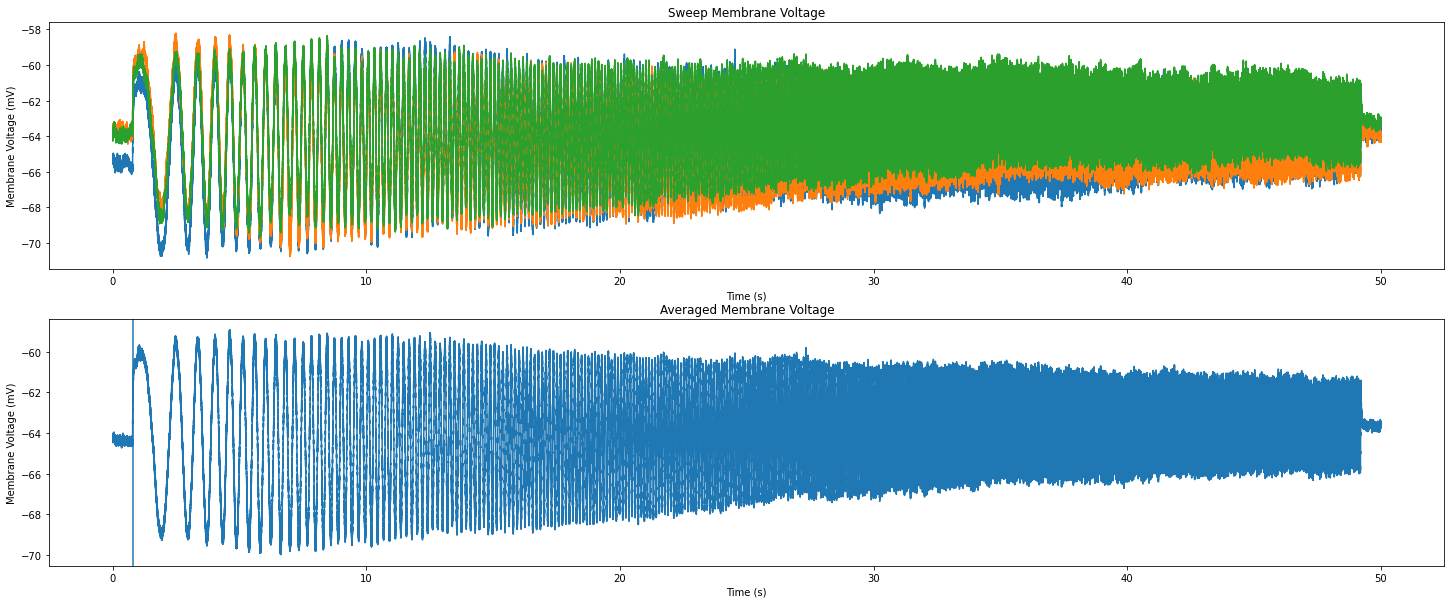

In [5]:
plt.figure(2, figsize=(25,10))
plt.subplot(2,1,1)
for x in v_list:
    
    plt.plot(t, x)
plt.ylabel("Membrane Voltage (mV)")
plt.xlabel("Time (s)")
plt.title("Sweep Membrane Voltage")
plt.subplot(2,1,2)
plt.ylabel("Membrane Voltage (mV)")
plt.xlabel("Time (s)")
plt.title("Averaged Membrane Voltage")
plt.plot(t, ds_v)
plt.axvline(0.78)

Define the Freq range, as well as the time range:

In [6]:
start=0.78089; end=49.21 #Preset based on the Clampex 20hz in 50s, clampex seems to put a slight delay in the start and end of protocols
min_freq=1; max_freq=19.5
start_index = tsu.find_time_index(ds_t, start)
end_index = tsu.find_time_index(ds_t, end)

N = len(ds_v[start_index:end_index])
T = ds_t[1] - ds_t[0]
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
low_ind = tsu.find_time_index(xf, min_freq)
high_ind = tsu.find_time_index(xf, max_freq)

Compute the fourier transformation of the data. Then compute the ratio of the of the input fourier data to the membrane response as:
$$
V = I*R
$$
$$
|R|=\frac{|V|}{|I|}
$$
$$
|R|=|{Z}_{{\rm{rm}}}|
$$
As
$$
|{Z}_{{\rm{rm}}}|=\frac{FFT(V)}{FFT(I)}
$$

From [https://www.nature.com/articles/s41598-018-28232-0#Sec8](https://www.nature.com/articles/s41598-018-28232-0#Sec8)

In [7]:
v_fft = fftpack.fft(ds_v[start_index:end_index]) #Compute the Fourier Transformation of The voltage
i_fft = fftpack.fft(ds_i[start_index:end_index]) #Compute the Fourier Transformation of The Input
Z = v_fft / i_fft #Take the Ratio of transformation
resistance = np.abs(Z)[0:N//2] #drop the imaginary values of the transformation

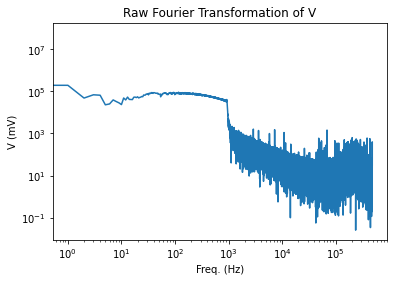

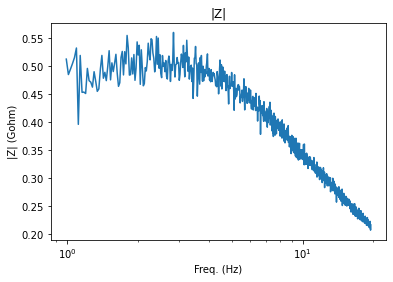

In [8]:
plt.figure(1)
plt.plot(np.abs(v_fft)[0:N//2])
plt.title("Raw Fourier Transformation of V")
plt.ylabel("V (mV)")
plt.xlabel("Freq. (Hz)")
plt.xscale("log")
plt.yscale("log")
plt.figure(2)
plt.title("|Z|")
plt.plot(xf[low_ind:high_ind],resistance[low_ind:high_ind])
plt.xlabel("Freq. (Hz)")
plt.ylabel("|Z| (Gohm)")
plt.xscale("log")

Now compute the reactance as:
$$
|Z|=\sqrt{Z\cdot {Z}^{\ast }}
$$

$$
\text{arg}(Z)={\tan }^{-1}(\frac{{\rm{Im}}[Z]}{{\rm{Re}}[Z]})
$$

Where Z is the relationship between the voltage V and input current I

also from: [https://www.nature.com/articles/s41598-018-28232-0#Sec8](https://www.nature.com/articles/s41598-018-28232-0#Sec8)

In [9]:
R = np.real(Z) #Take the real component
X = np.imag(Z) #Take the imaginary Component
reactance = np.arctan(X / R)[0:N//2] # Compute the angle between the real and imaginary components which represents the freq dependant phase

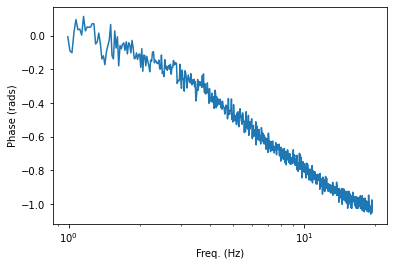

In [10]:
plt.plot(xf[low_ind:high_ind], reactance[low_ind:high_ind])
plt.xlabel("Freq. (Hz)")
plt.ylabel("Phase (rads)")
plt.xscale("log")

## Compute the moving Averages

In [11]:
def moving_avg(ar, window):
    series_ar = pd.Series(data=ar) #Indicate the data is a time series
    running_mean = series_ar.rolling(window).mean().to_numpy() #Take the running mean in the forward direction
    series_ar = pd.Series(data=np.flip(ar)) #Flip the data
    running_mean_start = series_ar.rolling(window).mean().to_numpy() #Take the running mean in the reverse direction
    replace = int(window-1) #
    running_mean[:replace] = running_mean_start[-replace:] #Replace the beginning of the running mean with the propely computed mean
    return running_mean

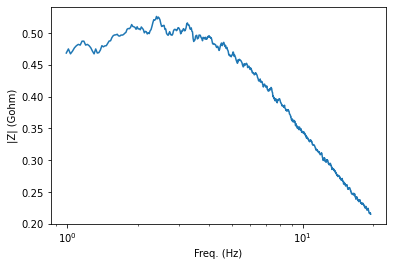

In [12]:
running_mean =  moving_avg(resistance[low_ind:high_ind], 10) #computes the moving average across 10 points
plt.plot(xf[low_ind:high_ind],running_mean) 
plt.xlabel("Freq. (Hz)")
plt.ylabel("|Z| (Gohm)")
plt.xscale("log")
plt.xscale("log")

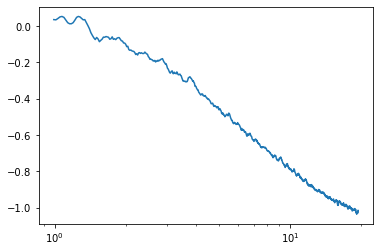

In [13]:
running_mean =  moving_avg(reactance[low_ind:high_ind], 10) #computes the moving average across 10 points
plt.plot(xf[low_ind:high_ind], running_mean)
plt.xscale("log")